In [1]:
import pandas as pd
import tkinter as tk
import warnings
import os
from tkinter import messagebox
from datetime import datetime
import calendar

warnings.filterwarnings('ignore')

def obtener_fecha(mes_anterior=False):
    hoy = datetime.now()
    
    if mes_anterior:
        if hoy.month == 1:
            mes = 12
            año = hoy.year - 1
        else:
            mes = hoy.month - 1
            año = hoy.year
    else:
        mes = hoy.month
        año = hoy.year
    
    mes_nombre = calendar.month_abbr[mes].upper()[:3] # ENE
    mes_año = f"{mes_nombre}{str(año)[2:]}" # ENE24
    fecha = f"{año}{str(mes).zfill(2)}" # 202401
    
    return mes_año, fecha

root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()

result = messagebox.askquestion('Confirmación', '¿Cargar mes anterior?', icon='warning')
if result == 'yes':
    mes_año, fecha = obtener_fecha(mes_anterior=True)
else:
    mes_año, fecha = obtener_fecha()
root.destroy()

efectividades_path = f'bases/efectividades/{fecha}/Efectividades_{fecha}.xlsx'
dashboard_efect_path = f'dashboard/{fecha}/DASHBOARD_EFECTIVIDADES_{mes_año}.xlsx'
dashboard_saldos_path = f'dashboard/{fecha}/DASHBOARD_SALDOS_{mes_año}.xlsx'
dashboard_indicadores_path = f'dashboard/{fecha}/DASHBOARD_INDICADORES_{mes_año}.xlsx'

dashboard_efect_path = os.path.abspath(dashboard_efect_path)
dashboard_saldos_path = os.path.abspath(dashboard_saldos_path)
dashboard_indicadores_path = os.path.abspath(dashboard_indicadores_path)

print(efectividades_path)
print(dashboard_efect_path)
print(dashboard_saldos_path)
print(dashboard_indicadores_path)

bases/efectividades/202411/Efectividades_202411.xlsx
c:\Users\p042833\Documents\GitHub\base-pagos\dashboard\202411\DASHBOARD_EFECTIVIDADES_NOV24.xlsx
c:\Users\p042833\Documents\GitHub\base-pagos\dashboard\202411\DASHBOARD_SALDOS_NOV24.xlsx
c:\Users\p042833\Documents\GitHub\base-pagos\dashboard\202411\DASHBOARD_INDICADORES_NOV24.xlsx


In [2]:
def clean_columns(columns_list: list[str]) -> list[str]:
    return [column.strip().replace('.', '').replace(' ', '_').upper() for column in columns_list]

In [3]:
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()

result = messagebox.askquestion('Confirmación', '¿Cargar efectividades?', icon='warning')
if result == 'yes':
    df_pagos = pd.read_excel(efectividades_path, sheet_name='BD')
    print('Base Efectividades:', df_pagos.shape)

root.destroy()

Base Efectividades: (231499, 110)


In [4]:
cols_req = ['PERIODO', 'CLAVE', 'AGENCIA', 'CAPITALSOLES', 'PAGOEFECTTOTALSOLESAGENCIACONT', 'DESC_TRAMO',  
            'SEGMENTO_RIESGO', 'AMBITO_RCD_FINAL', 'INTENSIDAD', 'DIRECTO_CALL', 'COBERTURA', 'CONTACTO_EFECTIVO', 'TASA_CIERRE', 'PDP', 'PDP_CUMPLIDA', 'ESTADO']

In [5]:
df_test = df_pagos.copy()
df_test.columns = clean_columns(df_test.columns)
df_test = df_test[cols_req]
print(df_test.shape)
df_test.head(5)

(231499, 16)


,PERIODO,CLAVE,AGENCIA,CAPITALSOLES,PAGOEFECTTOTALSOLESAGENCIACONT,DESC_TRAMO,SEGMENTO_RIESGO,AMBITO_RCD_FINAL,INTENSIDAD,DIRECTO_CALL,COBERTURA,CONTACTO_EFECTIVO,TASA_CIERRE,PDP,PDP_CUMPLIDA,ESTADO
0,202410,BC,ASESCOM RJ,107201.25,0.0,< 01 año,PYME/EMPRESAS MINORISTAS,5.Pymes,103,0,1,0.0,NaN,0,NaN,STOCK
1,202410,BC,ASESCOM RJ,78715.77,0.0,< 01 año,PYME/EMPRESAS MINORISTAS,5.Pymes,3,0,1,0.0,NaN,0,NaN,STOCK
2,202410,BC,ASESCOM RJ,188995.94,0.0,< 01 año,PYME/EMPRESAS MINORISTAS,5.Pymes,3,0,1,0.0,NaN,0,NaN,STOCK
3,202410,BC,ASESCOM RJ,100000.00,0.0,< 01 año,PYME/EMPRESAS MINORISTAS,5.Pymes,145,1,1,1.0,0.0,0,NaN,STOCK
4,202410,BC,ASESCOM RJ,2805.26,0.0,< 01 año,PARTICULARES,3.Tarjetas,11,0,1,0.0,NaN,0,NaN,NUEVO


In [18]:
numeric_df_test = df_test.select_dtypes(include=['number'])
correlation_matrix = numeric_df_test.corr()
correlation_matrix

,PERIODO,CAPITALSOLES,PAGOEFECTTOTALSOLESAGENCIACONT,INTENSIDAD,DIRECTO_CALL,COBERTURA,CONTACTO_EFECTIVO,TASA_CIERRE,PDP,PDP_CUMPLIDA
PERIODO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAPITALSOLES,NaN,1.000000,0.062595,0.250291,0.075828,0.024114,0.049969,-0.015059,0.022337,-0.016167
PAGOEFECTTOTALSOLESAGENCIACONT,NaN,0.062595,1.000000,0.021755,0.272984,0.005997,0.131108,0.143423,0.292480,0.226133
INTENSIDAD,NaN,0.250291,0.021755,1.000000,0.151353,0.081238,0.139871,-0.039199,0.045227,-0.327591
DIRECTO_CALL,NaN,0.075828,0.272984,0.151353,1.000000,0.038016,0.675414,0.257732,0.609292,0.077324
COBERTURA,NaN,0.024114,0.005997,0.081238,0.038016,1.000000,NaN,NaN,0.023475,NaN
CONTACTO_EFECTIVO,NaN,0.049969,0.131108,0.139871,0.675414,NaN,1.000000,NaN,0.416247,0.044421
TASA_CIERRE,NaN,-0.015059,0.143423,-0.039199,0.257732,NaN,NaN,1.000000,0.831916,-0.317561
PDP,NaN,0.022337,0.292480,0.045227,0.609292,0.023475,0.416247,0.831916,1.000000,NaN
PDP_CUMPLIDA,NaN,-0.016167,0.226133,-0.327591,0.077324,NaN,0.044421,-0.317561,NaN,1.000000


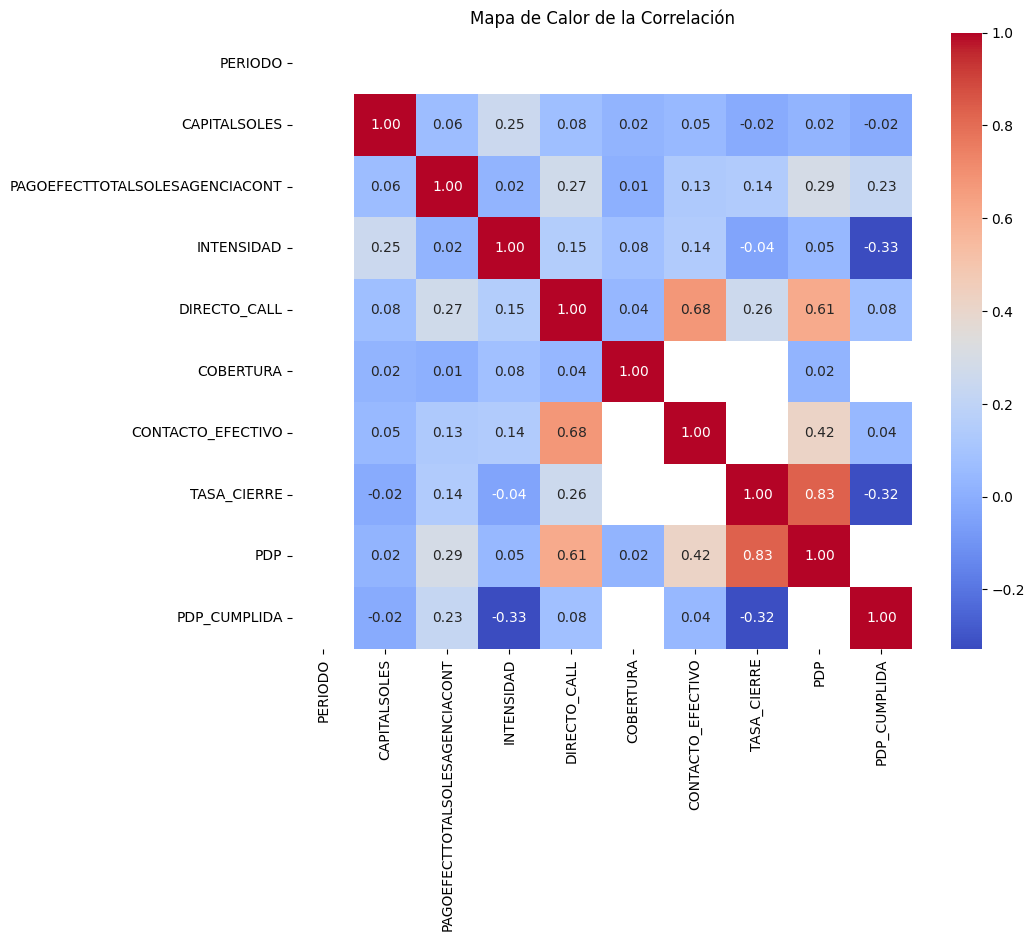

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de la Correlación')
plt.show()

In [ ]:
df_test['DESC_TRAMO'].value_counts(dropna=False)

In [ ]:
cols =  ['PERIODO', 'CLAVE', 'AGENCIA', 'INTENSIDAD', 'DIRECTO_CALL', 'COBERTURA', 'CONTACTO_EFECTIVO', 'TASA_CIERRE', 'PDP', 'PDP_CUMPLIDA']
df_test = df_test[cols]
print(df_test.shape)

df_test.rename(columns={
    'CLAVE': 'CARTERA', 
    'INTENSIDAD': 'INTENSIDAD_TOTAL', 
    'DIRECTO_CALL': 'INTENSIDAD_DIRECTA', 
    'CONTACTO_EFECTIVO': 'CONTACTO_DIRECTO', 
    }, inplace=True)

df_test = df_test[df_test['AGENCIA'].isin(['ASESCOM RJ', 'CLASA MORA', 'MORNESE MORA'])]

df_test['INTENSIDAD_TOTAL'] = df_test['INTENSIDAD_TOTAL'].fillna(0)
df_test['INTENSIDAD_DIRECTA'] = df_test['INTENSIDAD_DIRECTA'].fillna(0)
df_test['COBERTURA'] = df_test['COBERTURA'].fillna(0)
df_test['CONTACTO_DIRECTO'] = df_test['CONTACTO_DIRECTO'].fillna('NULL')
df_test['TASA_CIERRE'] = df_test['TASA_CIERRE'].fillna('NULL')
df_test['PDP'] = df_test['PDP'].fillna(0)
df_test['PDP_CUMPLIDA'] = df_test['PDP_CUMPLIDA'].fillna('NULL')
# convierte 'NULL' en NaN
df_test['COBERTURA'] = pd.to_numeric(df_test['COBERTURA'], errors='coerce')
df_test['CONTACTO_DIRECTO'] = pd.to_numeric(df_test['CONTACTO_DIRECTO'], errors='coerce')
df_test['TASA_CIERRE'] = pd.to_numeric(df_test['TASA_CIERRE'], errors='coerce')
df_test['PDP_CUMPLIDA'] = pd.to_numeric(df_test['PDP_CUMPLIDA'], errors='coerce')

df_test = df_test.groupby(['PERIODO', 'CARTERA', 'AGENCIA']).agg({
    'INTENSIDAD_TOTAL': 'mean', 
    'INTENSIDAD_DIRECTA': lambda x: x[x != 0].mean(),
    'COBERTURA': 'mean', 
    'CONTACTO_DIRECTO': lambda x: x.mean(skipna=True), 
    'TASA_CIERRE': lambda x: x.mean(skipna=True), 
    'PDP': 'mean',
    'PDP_CUMPLIDA': lambda x: x.mean(skipna=True)
    }).reset_index()

df_test['INTENSIDAD_TOTAL'] = df_test['INTENSIDAD_TOTAL'].round(2)
df_test['INTENSIDAD_DIRECTA'] = df_test['INTENSIDAD_DIRECTA'].round(2)
df_test['COBERTURA'] = df_test['COBERTURA'].round(2)
df_test['CONTACTO_DIRECTO'] = df_test['CONTACTO_DIRECTO'].round(2)
df_test['TASA_CIERRE'] = df_test['TASA_CIERRE'].round(2)
df_test['PDP'] = df_test['PDP'].round(2)
df_test['PDP_CUMPLIDA'] = df_test['PDP_CUMPLIDA'].round(2)

df_test.sort_values(by=['PERIODO', 'CARTERA', 'AGENCIA'], inplace=True)

In [ ]:
df_test.to_excel(dashboard_indicadores_path, index=False)

In [ ]:
df_pagos_efect = df_pagos.copy()
df_pagos_saldos = df_pagos.copy()
df_pagos_indicadores = df_pagos.copy()

In [ ]:
def dashboard_efectividades(df_pagos_efect: pd.DataFrame) -> pd.DataFrame:
    df_pagos_efect.columns = clean_columns(df_pagos_efect.columns)
    cols =  ['PERIODO', 'CLAVE', 'AGENCIA', 'CAPITALSOLES', 'PAGOEFECTTOTALSOLESAGENCIACONT']
    df_pagos_efect = df_pagos_efect[cols]
    print(df_pagos_efect.shape)
    
    df_pagos_efect.rename(columns={
        'CLAVE': 'CARTERA', 
        'CAPITALSOLES': 'CAPITAL', 
        'PAGOEFECTTOTALSOLESAGENCIACONT': 'RECUPERO', 
    }, inplace=True)
    
    df_pagos_efect = df_pagos_efect[df_pagos_efect['AGENCIA'].isin(['ASESCOM RJ', 'CLASA MORA', 'MORNESE MORA'])]
    df_pagos_efect['CAPITAL'] = df_pagos_efect['CAPITAL'].round(2)
    df_pagos_efect['RECUPERO'] = df_pagos_efect['RECUPERO'].round(2)
    
    df_pagos_efect = df_pagos_efect.groupby(['PERIODO', 'CARTERA', 'AGENCIA']).agg({'RECUPERO': 'sum', 'CAPITAL': 'sum'}).reset_index()
    
    return df_pagos_efect

In [ ]:
def dashboard_saldos(df_pagos_saldos: pd.DataFrame) -> pd.DataFrame:
    df_pagos_saldos.columns = clean_columns(df_pagos_saldos.columns)
    cols =  ['PERIODO', 'CLAVE', 'AGENCIA', 'CAPITALSOLES', 'SEGMENTO_RIESGO', 'AMBITO_RCD_FINAL']
    df_pagos_saldos = df_pagos_saldos[cols]
    print(df_pagos_saldos.shape)
    
    df_pagos_saldos.rename(columns={
        'CLAVE': 'CARTERA', 
        'CAPITALSOLES': 'CAPITAL', 
        'SEGMENTO_RIESGO': 'SEGMENTO', 
        'AMBITO_RCD_FINAL': 'PRODUCTO'
    }, inplace=True)
    
    df_pagos_saldos = df_pagos_saldos[df_pagos_saldos['AGENCIA'].isin(['ASESCOM RJ', 'CLASA MORA', 'MORNESE MORA', 'SIN AGENCIA'])]
    
    df_pagos_saldos['SEGMENTO'] = df_pagos_saldos['SEGMENTO'].apply(lambda x: 'PYME / EMP MIN' if x != 'PARTICULARES' else x)
    df_pagos_saldos['PRODUCTO'] = df_pagos_saldos['PRODUCTO'].str.replace(r'\d+', '', regex=True).str.replace('.', '').str.upper()
    df_pagos_saldos['PRODUCTO'] = df_pagos_saldos['PRODUCTO'].str.strip().replace(' ', '')
    df_pagos_saldos['CAPITAL'] = df_pagos_saldos['CAPITAL'].round(2)
    
    df_pagos_saldos = df_pagos_saldos.groupby(['PERIODO', 'CARTERA', 'AGENCIA', 'SEGMENTO', 'PRODUCTO']).agg({'CAPITAL': 'sum'}).reset_index()
    
    return df_pagos_saldos

In [ ]:
def dashboard_indicadores(df_pagos_indicadores: pd.DataFrame) -> pd.DataFrame:
    df_pagos_indicadores.columns = clean_columns(df_pagos_indicadores.columns)
    cols =  ['PERIODO', 'CLAVE', 'AGENCIA', 'INTENSIDAD', 'DIRECTO_CALL', 'CONTACTO_EFECTIVO', 'TASA_CIERRE', 'PDP_CUMPLIDA']
    df_pagos_indicadores = df_pagos_indicadores[cols]
    print(df_pagos_indicadores.shape)
    
    df_pagos_indicadores.rename(columns={
        'CLAVE': 'CARTERA', 
        'INTENSIDAD': 'INTENSIDAD_TOTAL', 
        'DIRECTO_CALL': 'INTENSIDAD_DIRECTA', 
        'CONTACTO_EFECTIVO': 'CONTACTABILIDAD_DIRECTA', 
        'PDP_CUMPLIDA': 'CALIDAD_PROMESAS'
        }, inplace=True)
    
    df_pagos_indicadores = df_pagos_indicadores[df_pagos_indicadores['AGENCIA'].isin(['ASESCOM RJ', 'CLASA MORA', 'MORNESE MORA'])]
    
    df_pagos_indicadores['INTENSIDAD_TOTAL'] = df_pagos_indicadores['INTENSIDAD_TOTAL'].fillna(0)
    df_pagos_indicadores['INTENSIDAD_DIRECTA'] = df_pagos_indicadores['INTENSIDAD_DIRECTA'].fillna(0)
    df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'] = df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'].fillna('NULL')
    df_pagos_indicadores['TASA_CIERRE'] = df_pagos_indicadores['TASA_CIERRE'].fillna('NULL')
    df_pagos_indicadores['CALIDAD_PROMESAS'] = df_pagos_indicadores['CALIDAD_PROMESAS'].fillna('NULL')
    # convierte 'NULL' en NaN
    df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'] = pd.to_numeric(df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'], errors='coerce')
    df_pagos_indicadores['TASA_CIERRE'] = pd.to_numeric(df_pagos_indicadores['TASA_CIERRE'], errors='coerce')
    df_pagos_indicadores['CALIDAD_PROMESAS'] = pd.to_numeric(df_pagos_indicadores['CALIDAD_PROMESAS'], errors='coerce')
    
    df_pagos_indicadores = df_pagos_indicadores.groupby(['PERIODO', 'CARTERA', 'AGENCIA']).agg({
        'INTENSIDAD_TOTAL': 'mean', 
        'INTENSIDAD_DIRECTA': lambda x: x[x != 0].mean(),
        'CONTACTABILIDAD_DIRECTA': lambda x: x.mean(skipna=True), 
        'TASA_CIERRE': lambda x: x.mean(skipna=True), 
        'CALIDAD_PROMESAS': lambda x: x.mean(skipna=True)
        }).reset_index()
    
    df_pagos_indicadores['INTENSIDAD_TOTAL'] = df_pagos_indicadores['INTENSIDAD_TOTAL'].round(2)
    df_pagos_indicadores['INTENSIDAD_DIRECTA'] = df_pagos_indicadores['INTENSIDAD_DIRECTA'].round(2)
    df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'] = df_pagos_indicadores['CONTACTABILIDAD_DIRECTA'].round(2)
    df_pagos_indicadores['TASA_CIERRE'] = df_pagos_indicadores['TASA_CIERRE'].round(2)
    df_pagos_indicadores['CALIDAD_PROMESAS'] = df_pagos_indicadores['CALIDAD_PROMESAS'].round(2)
    
    df_pagos_indicadores.sort_values(by=['PERIODO', 'CARTERA', 'AGENCIA'], inplace=True)
    
    return df_pagos_indicadores

In [ ]:
df_pagos_efect = dashboard_efectividades(df_pagos_efect)
df_pagos_efect.to_excel(dashboard_efect_path, index=False)
print(df_pagos_efect.shape)
df_pagos_efect.head()

In [ ]:
df_pagos_saldos = dashboard_saldos(df_pagos_saldos)
df_pagos_saldos.to_excel(dashboard_saldos_path, index=False)
print(df_pagos_saldos.shape)
df_pagos_saldos.head()

In [ ]:
df_pagos_indicadores = dashboard_indicadores(df_pagos_indicadores)
df_pagos_indicadores.to_excel(dashboard_indicadores_path, index=False)
print(df_pagos_indicadores.shape)
df_pagos_indicadores.head()

In [ ]:
os.startfile(dashboard_efect_path)
os.startfile(dashboard_saldos_path)
os.startfile(dashboard_indicadores_path)